In [1]:
# Import torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# Helper packages
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
# Generate the transformations that we will apply to the images
from torchvision import transforms
# Chain together scaling and cropping transformations
# We will also convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
    transforms.ToTensor()
])

In [3]:
# Load the MNIST training and test datasets using torchvision
# We will transform the images using the transformations we just defined
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [4]:
# Create the training and test dataloaders
# We will use a batch size of 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

torch.Size([32, 1, 28, 28])


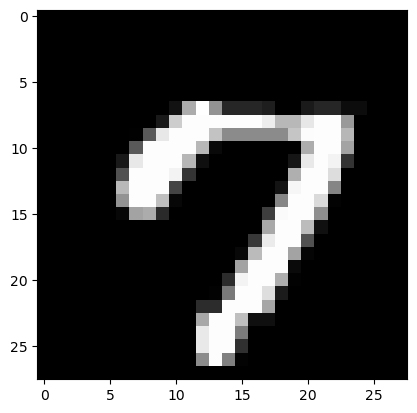

In [5]:
# View an MNIST image using MNIST and look at the shape of a batch
image, label = next(iter(train_loader))
print(image.shape)

# Plot the first image in the batch
plt.imshow(image[0, 0], cmap='gray')
plt.show()

In [8]:
# Build the critic network class
# This will have a standard convolutional architecture
# The output will be a single value which scores the input image. 

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        # This takes in an image of size 28x28 and 1 input channel and outputs a single value
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # 28x28x1 -> 28x28x32 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 28x28x32 -> 14x14x32 
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 14x14x32 -> 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 14x14x64 -> 7x7x64 
            nn.Conv2d(64, 8, kernel_size=3), # 7x7x64 -> 5x5x8
            nn.Flatten(),
            nn.Linear(5*5*8, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [12]:
# Build the generator network class
# The generator network takes in a random vector and outputs an image of the same shape as an MNIST image
# The random vector is a 24 dimensional Gaussian distribution with mean 0 and variance 1
# The generator network will have a standard deconvolutional architecture

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # This takes in a random vector of size 24 and outputs an image of size 28x28
        self.layers = nn.Sequential(
            nn.Linear(24, 4*7*7), # 24 -> 198
            nn.Unflatten(1, (4, 7, 7)),
            nn.ConvTranspose2d(4, 32, kernel_size=3, padding=1), # 7x7x4 -> 7x7x32
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 7x7x32 -> 14x14x32
            nn.ConvTranspose2d(32, 64, kernel_size=3, padding=1), # 14x14x64 -> 14x14x32
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 14x14x32 -> 28x28x32
            nn.ConvTranspose2d(64, 16, kernel_size=3, padding=1), # 28x28x32 -> 28x28x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1) # 28x28x16 -> 28x28x1
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
# Instantiate the generator and critic networks
generator = Generator()
critic = Critic()

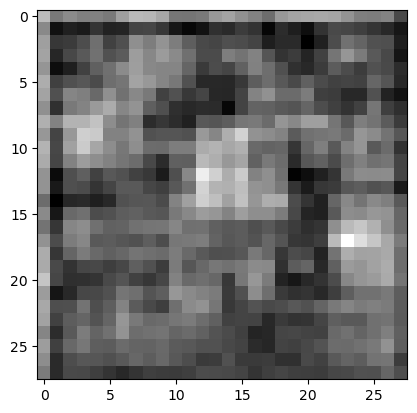

tensor([[0.0003]], grad_fn=<AddmmBackward0>)


In [36]:
# View the output of the generator network before training
# This should be a random image

# Generate a random vector
z = torch.randn(1, 24)
# Pass it through the generator
out = generator(z)
# Plot the output
plt.imshow(out.detach().numpy()[0, 0], cmap='gray')
plt.show()

# Pass the output of the generator through the critic
# This should be a single value
out = critic(out)
print(out)

In [37]:
# Define the optimisers for the generator and critic networks
# We will use the Adam optimiser 
g_optim = optim.Adam(generator.parameters(), lr=0.0001)
c_optim = optim.Adam(critic.parameters(), lr=0.0002)

In [58]:
# Train the generator and critic networks using the Wasserstein loss with L2 weight regularisation. 

# The Wasserstein loss for the critic network is C(G(Z)) - C(X) where Z is a random vector and X is a real image. 
# This encourages the critic to score real images highly and generated images poorly. 

# The Wasserstein loss for the generator network is -C(G(Z)) where Z is a random vector.
# This encourages the generator to generate images that the critic scores highly.

# Define a list to store the losses for the generator and critic networks
g_losses = []
c_losses = []

L2_weight = 0.01

for epoch in range(4):
    for real_images, _ in tqdm(train_loader):
        # Train the critic. 
        # Zero the gradients for the optimiser
        c_optim.zero_grad()
        # Generate a random vector
        z = torch.randn(48, 24)
        # Pass it through the generator
        fake_images = generator(z)
        # Find the squared L2 norm of the critic parameters
        # critic_L2 = torch.tensor(0.0)
        # for param in critic.parameters():
        #     critic_L2 += torch.sum(param**2)
        critic_loss = critic(fake_images).mean() - critic(real_images).mean() + L2_weight*( (critic(fake_images)**2).mean() + (critic(real_images)**2).mean() ) 
        critic_loss.backward()
        c_losses.append(critic_loss.item())
        c_optim.step()

        # Train the generator
        # Zero the gradients for the 
        g_optim.zero_grad()
        # Generate a random vector
        z = torch.randn(32, 24)
        # Pass it through the generator
        fake_images = generator(z)
        genertor_loss = -critic(fake_images).mean()
        genertor_loss.backward()
        g_losses.append(genertor_loss.item())
        g_optim.step()


100%|██████████| 1875/1875 [08:41<00:00,  3.59it/s]


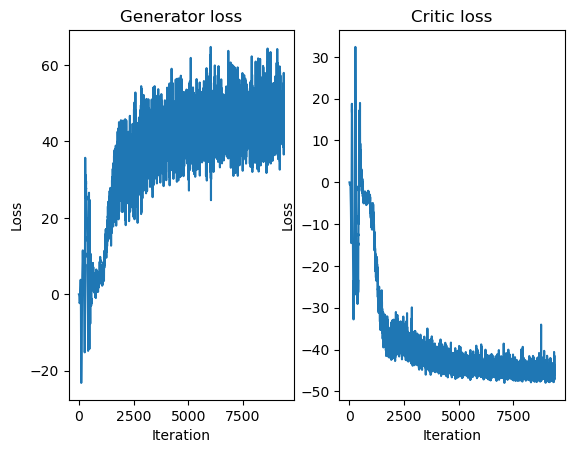

In [59]:
# Plot the losses for the generator and critic networks side by side on two subplots
plt.subplot(1, 2, 1)
plt.plot(g_losses)
plt.title('Generator loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(c_losses)
plt.title('Critic loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


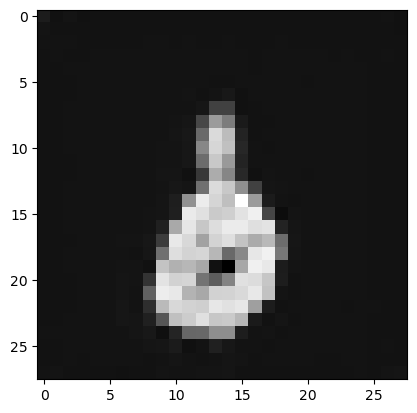

In [76]:
# Generate an image using the generator network and plot them using matplotlib

# Generate a random vector
z = torch.randn(1, 24)
# Pass it through the generator
out = generator(z)
# Plot the output
plt.imshow(out.detach().numpy()[0, 0], cmap='gray')
plt.show()